In [1]:
import torch
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ]
)
trainset = datasets.MNIST(
    root='./data', 
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=100,  # minibatchのbatch size
    shuffle=True,
    num_workers=2
)
testset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=100,
    shuffle=False, 
    num_workers=2
)

In [27]:
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x1 -(3x3x32)-> 26x26x32  # 2D convolution
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x32 -(3x3x2)-> 24x24x64  # 2D convolution
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout05 = nn.Dropout2d() # default: p = 0.5
        self.dropout02 = nn.Dropout2d(p=0.2)

    def forward(self, x):
        self.dropout02(x) # 入力層はdropout ratio: 0.2
        x = nn.functional.relu(self.conv1(x))
        self.dropout02(x) # 全結合層以外はdropout ratio: 0.2
        x = nn.functional.relu(self.conv2(x))
        self.dropout05(x)
        x = self.pool(x)
        x = x.view(-1, 12 * 12 * 64)
        self.dropout05(x)
        x = nn.functional.relu(self.fc1(x))
        self.dropout05(x)
        x = self.fc2(x)
        return x

In [28]:
from torch import optim

if __name__ == '__main__':
    epochs = int(input())
    
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=0.01,  # 学習係数
        momentum=0.8,  # 慣性係数
        nesterov=True  
    )
    
    print('Start Training')
    
    net.train() # train modeに設定
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 1):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs) # forwardメソッドが実行され、Tensorオブジェクトとして出力される。
            loss = criterion(outputs, labels) # outputsとlabelsからloss funcを計算してTensorオブジェクトとして返される。
            loss.backward()　#  loss.item()から各parameterの勾配を計算して、parameter.gradに記憶する。
                                         # lossはTensorオブジェクトでgrad_fnアトリビュートから全parameterを追跡できる。
                                         # このgrad_fnの値はoutputsに記憶されていたものでoutputsから渡される。
            optimizer.step() # parameter.gradを利用してparameterを更新

            # print statistics
            running_loss += loss.item()
            if i % 100 == 0:
                print(f'[{epoch: d}, {i: 5d}] loss: {running_loss/100: .3f}')
                running_loss = 0.0

    print('Finished Training')


    correct = 0
    total = 0

    net.eval() # eval modeに設定。dropoutがdeactivateされる
    with torch.no_grad():
        for (images, labels) in testloader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: {:.2f} %'.format(100 * float(correct/total)))

5
Start Training
[ 1,   100] loss:  1.210
[ 1,   200] loss:  0.331
[ 1,   300] loss:  0.237
[ 1,   400] loss:  0.188
[ 1,   500] loss:  0.150
[ 1,   600] loss:  0.126
[ 2,   100] loss:  0.101
[ 2,   200] loss:  0.098
[ 2,   300] loss:  0.086
[ 2,   400] loss:  0.081
[ 2,   500] loss:  0.071
[ 2,   600] loss:  0.067
[ 3,   100] loss:  0.061
[ 3,   200] loss:  0.060
[ 3,   300] loss:  0.060
[ 3,   400] loss:  0.052
[ 3,   500] loss:  0.051
[ 3,   600] loss:  0.055
[ 4,   100] loss:  0.042
[ 4,   200] loss:  0.048
[ 4,   300] loss:  0.040
[ 4,   400] loss:  0.043
[ 4,   500] loss:  0.044
[ 4,   600] loss:  0.039
[ 5,   100] loss:  0.032
[ 5,   200] loss:  0.030
[ 5,   300] loss:  0.034
[ 5,   400] loss:  0.036
[ 5,   500] loss:  0.036
[ 5,   600] loss:  0.040
Finished Training
Accuracy: 98.60 %


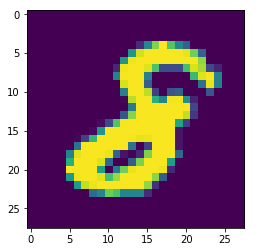

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

images, labels = iter(trainloader).next()
plt.imshow(images[0].numpy().reshape(28, 28))